**Entrega 4**

In [95]:
#Importar bibliotecas
from google.colab import drive
import sklearn.linear_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


#Dar load dos dados
#X_train_a=np.load('/content/Xtrain2_a.npy')
#Y_train_a=np.load('/content/Ytrain2_a.npy')
X_train_b=np.load('/content/Xtrain2_b.npy')
Y_train_b=np.load('/content/Ytrain2_b.npy')
#X_test_a=np.load('/content/Xtest2_a.npy')
X_test_b=np.load('/content/Xtest2_b.npy')

print(X_train_b.shape)
print(Y_train_b.shape)

'''
cnt=0
for x in range (Y_train_b.shape[0]):
  if 1 in Y_train_b[x]:
    cnt=cnt+1

print(cnt)

for x in range (20,100):

  image=Y_train_b[x].reshape(48,48)
  plt.imshow(image,cmap='gray')
  plt.show()
  '''



(547, 2304)
(547, 2304)


"\ncnt=0\nfor x in range (Y_train_b.shape[0]):\n  if 1 in Y_train_b[x]:\n    cnt=cnt+1\n\nprint(cnt)\n\nfor x in range (20,100):\n\n  image=Y_train_b[x].reshape(48,48)\n  plt.imshow(image,cmap='gray')\n  plt.show()\n  "

**80% Train, 20% Validation or 100% Train**

In [96]:
from sklearn.model_selection import train_test_split

#x_train and y_train with 80% train and 20% validation
#X_b, x_val, Y_b, y_val = train_test_split(X_train_b, Y_train_b, test_size=0.2)

#x_train and y_train without dividing the dataset
X_b=X_train_b
Y_b=Y_train_b

**Data Augmentation**

In [103]:
import os
import numpy as np
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define multiple augmentation layers
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),       # Flip horizontally
    layers.GaussianNoise(0.05),                 # Add Gaussian noise with stddev of 0.05,
    layers.RandomRotation(0.25),            # Rotate by 10%
    #layers.RandomContrast(0.1),                 # Adjust contrast by 10%
    layers.RandomZoom(0.1),                # Zoom in/out by 10%
    layers.RandomTranslation(0.1, 0.1),              # Shift the image vertically by 10%               # Shift the image horizontally by 10%
    layers.RandomBrightness(0.1)           # Adjust brightness by 10%
]

image_augmentation = []
image_augmentationY=[]
# Function to apply augmentations
def data_augmentation(X_train, Y_train):
    for x in range(0,len(data_augmentation_layers)):
      layer=data_augmentation_layers[x]
      for y in range(0,(X_train.shape[0])):
        images = np.reshape(X_train[y], (48, 48, 1))
        images = layer(images)
        image_augmentation.append(images)

        imagesY = np.reshape(Y_train[y], (48, 48, 1))
        imagesY = layer(imagesY)
        image_augmentationY.append(imagesY)


data_augmentation(X_b, Y_b)

# Optionally, convert the list to a NumPy array if needed
image_augmentation = np.array(image_augmentation)
image_augmentationY = np.array(image_augmentationY)


**Junction of the original data with the augmented data**

In [104]:
# Reshape image_augmentation_array to have the same dimensions as x_train1
image_augmentation_array = image_augmentation.reshape(image_augmentation.shape[0], -1)
image_augmentationY_array = image_augmentationY.reshape(image_augmentationY.shape[0], -1)

# Combine the original X_train1 with the augmented images
print(X_b.shape)
print(Y_b.shape)
print(image_augmentation.shape)
print(image_augmentationY.shape)

x_combined = np.concatenate((X_b, image_augmentation_array), axis=0)
print(x_combined.shape)
# Generate corresponding labels
y_combined = np.concatenate((Y_b,image_augmentationY_array), axis=0)
print(y_combined.shape)

(547, 2304)
(547, 2304)
(3282, 48, 48, 1)
(3282, 48, 48, 1)
(3829, 2304)
(3829, 2304)


**Calculate class weights**

In [105]:
import numpy as np

# Calculate class weights (inverse of class frequencies)
# Reshape y_train to flatten it, so it's easier to calculate class weights
flat_labels = y_combined.flatten()

# Count number of pixels for each class (0 and 1)
class_0_count = np.sum(flat_labels == 0)
class_1_count = np.sum(flat_labels == 1)

# Calculate class weights (inverse of class frequencies)
total_pixels = len(flat_labels)
class_weight_0 = total_pixels / (2 * class_0_count)
class_weight_1 = total_pixels / (2 * class_1_count)

class_weights = {0: class_weight_0, 1: class_weight_1}
print(class_weights)


{0: 0.7529238261297038, 1: 2.1448226768272045}


**UNet**

In [100]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_size=(48, 48, 1)):
    inputs = layers.Input(input_size)

    # Encoder with Dropout
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(0.5)(p1)  # Dropout in encoder

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.5)(p2)  # Dropout in encoder

    # Bottleneck with Dropout
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.Dropout(0.5)(c3)  # Dropout in bottleneck

    # Decoder with Dropout
    u4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.Dropout(0.5)(c4)  # Dropout in decoder

    u5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.Dropout(0.5)(c5)  # Dropout in decoder

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Create U-Net model with Dropout
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 48, 48, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_55 (Conv2D)        │ (None, 48, 48, 64)     │            640 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 48, 48, 64)     │         36,928 │ conv2d_55[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 24, 24, 64)     │              0 │ conv2d_56[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_25 (Dropout)      │ (None, 24, 24, 64)     │              0 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 24, 24, 128)    │         73,856 │ dropout_25[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 24, 24, 128)    │        147,584 │ conv2d_57[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 12, 12, 128)    │              0 │ conv2d_58[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_26 (Dropout)      │ (None, 12, 12, 128)    │              0 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 12, 12, 256)    │        295,168 │ dropout_26[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 12, 12, 256)    │        590,080 │ conv2d_59[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_27 (Dropout)      │ (None, 12, 12, 256)    │              0 │ conv2d_60[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_10       │ (None, 24, 24, 128)    │        131,200 │ dropout_27[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_10            │ (None, 24, 24, 256)    │              0 │ conv2d_transpose_10[0… │
│ (Concatenate)             │                        │                │ conv2d_58[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_61 (Conv2D)        │ (None, 24, 24, 128)    │        295,040 │ concatenate_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 24, 24, 128)    │        147,584 │ conv2d_61[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_28 (Dropout)      │ (None, 24, 24, 128)    │              0 │ conv2d_62[0][0]        │
├──────────────────────

 Total params: 1,861,697 (7.10 MB)

 Trainable params: 1,861,697 (7.10 MB)

 Non-trainable params: 0 (0.00 B)

****

**RFC**

In [25]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

y_combined_binary = (Y_b > 0).astype(int)  # Converts any non-zero pixel to 1

# Step 2: Flatten the arrays for pixel-wise classification
x_flat = X_b.reshape(-1, 1)         # Shape: (3059 * 2304, 1)
y_flat = y_combined_binary.reshape(-1)     # Shape: (3059 * 2304,)

# Step 3: Initialize the Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Step 4: Train the classifier on the pixel data
rfc.fit(x_flat, y_flat)

# Step 5: Predict on new data (e.g., x_test)
# Assuming x_test has shape (num_test_samples, 2304)
# For demonstration, I'll use x_combined as x_test (replace with actual x_test when available)
x_test_flat = X_b.reshape(-1, 1)  # Replace x_combined with actual x_test data

# Predict the mask (crater vs. non-crater) for each pixel
y_test_flat = rfc.predict(x_test_flat)

# Step 6: Reshape y_test_flat back to the original image shape for each sample
num_samples = X_b.shape[0]  # Number of test images
y_test = y_test_flat.reshape(num_samples, 48, 48)  # Shape: (num_samples, 48, 48)

# y_test now contains the predicted crater masks for each image in x_test
print("Predicted mask shape for each image:", y_test.shape)


Predicted mask shape for each image: (437, 48, 48)


**RFC Balanced Accuracy**

Balanced Accuracy for the entire model: 0.5554


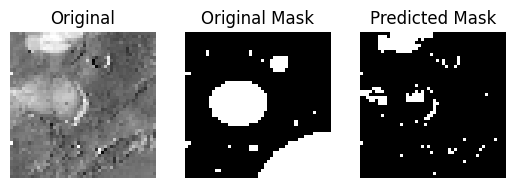

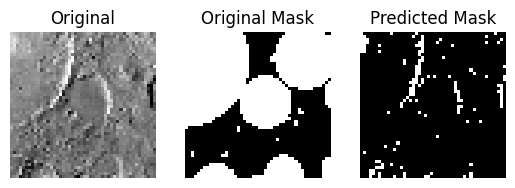

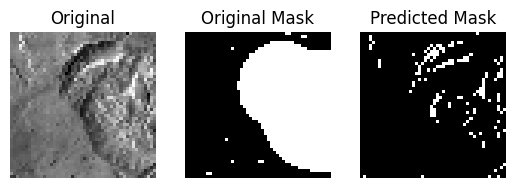

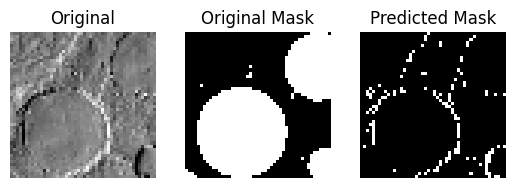

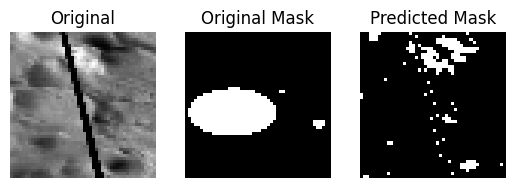

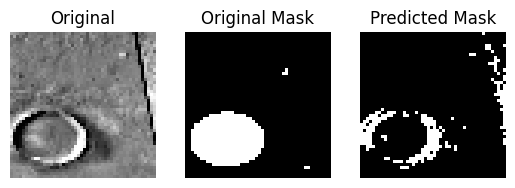

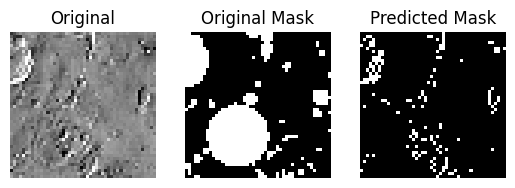

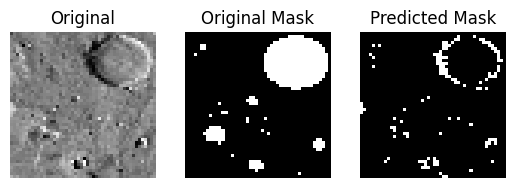

In [29]:
from sklearn.metrics import balanced_accuracy_score
y_pred_binary = (y_test > 0.60).astype(np.uint8)

# Flatten the ground truth masks and predicted masks across the entire dataset
y_true_flat = y_flat.flatten()
y_pred_flat = y_pred_binary.flatten()

# Calculate balanced accuracy for the entire dataset
balanced_acc = balanced_accuracy_score(y_true_flat, y_pred_flat)

# Output the balanced accuracy
print(f'Balanced Accuracy for the entire model: {balanced_acc:.4f}')

for x in range(0, 10):
    # Reshape the images back to 48x48 for visualization
    plt.subplot(1, 3, 1)
    plt.imshow(X_b[x].reshape(48, 48), cmap='gray')
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(Y_b[x].reshape(48, 48), cmap='gray')
    plt.title('Original Mask')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(y_test[x], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    # Display the images
    plt.show()


**Train the Model with Class Weights**

In [106]:
import numpy as np
import tensorflow as tf

# Train the model using sample weights (calculated below)
# Assuming x_train and y_train are properly reshaped to (547, 48, 48, 1) and (547, 48, 48, 1) respectively.
# Reshape your input data if necessary

x_train_reshaped = np.reshape(x_combined, (x_combined.shape[0], 48, 48, 1))
y_train_reshaped = np.reshape(y_combined, (y_combined.shape[0], 48, 48, 1))

# Create sample weights for each pixel
sample_weights = np.zeros_like(y_train_reshaped, dtype=np.float32)
sample_weights[y_train_reshaped == 0] = class_weights[0]
sample_weights[y_train_reshaped == 1] = class_weights[1]


# Train the model using sample weights
history = model.fit(x_train_reshaped, y_train_reshaped,
                    batch_size=16, epochs=20,
                    sample_weight=sample_weights,  # Use sample_weight instead of class_weight
                    validation_split=0.1)

Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7476 - loss: 0.5110 - val_accuracy: 0.3463 - val_loss: 0.3280
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7480 - loss: 0.5098 - val_accuracy: 0.3368 - val_loss: 0.3953
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7570 - loss: 0.4959 - val_accuracy: 0.3335 - val_loss: 0.3692
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7609 - loss: 0.4885 - val_accuracy: 0.3730 - val_loss: 0.3069
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7575 - loss: 0.4937 - val_accuracy: 0.3521 - val_loss: 0.3387
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7645 - loss: 0.4831 - val_accuracy: 0.3583 - val_loss: 0.3872
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7717 - loss: 0.4701 - val_accuracy: 0.3473 - val_loss: 0.3114
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7622 - loss: 0.4714 - val_accu

**Make Predictions**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Balanced Accuracy for the entire model: 0.9256


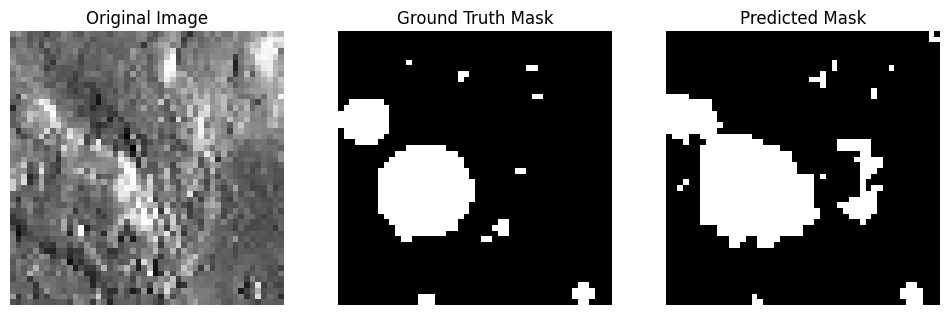

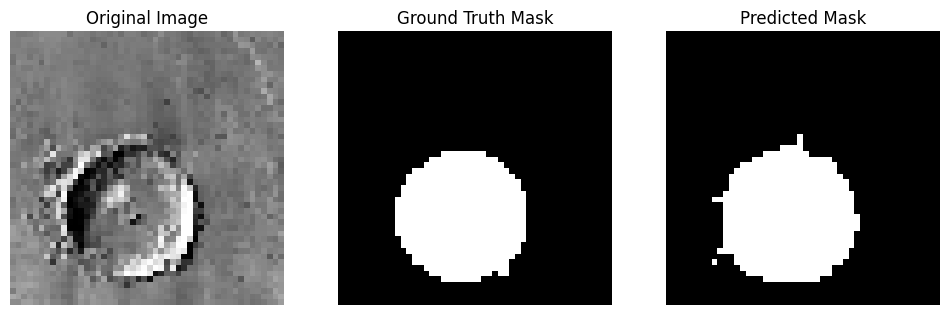

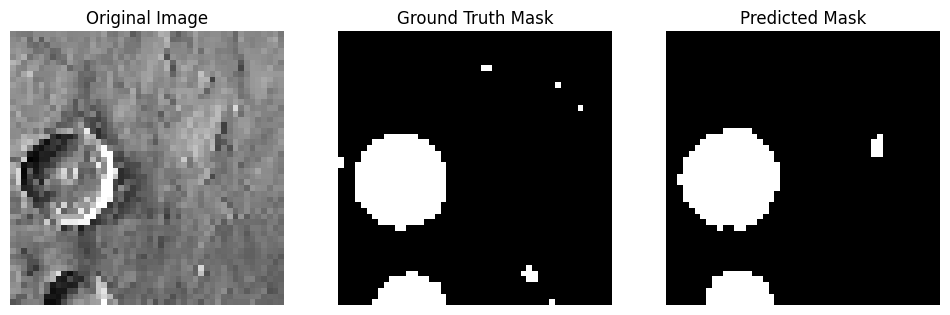

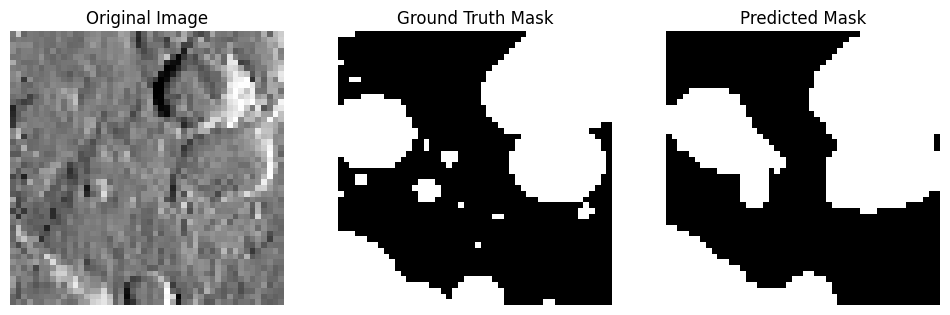

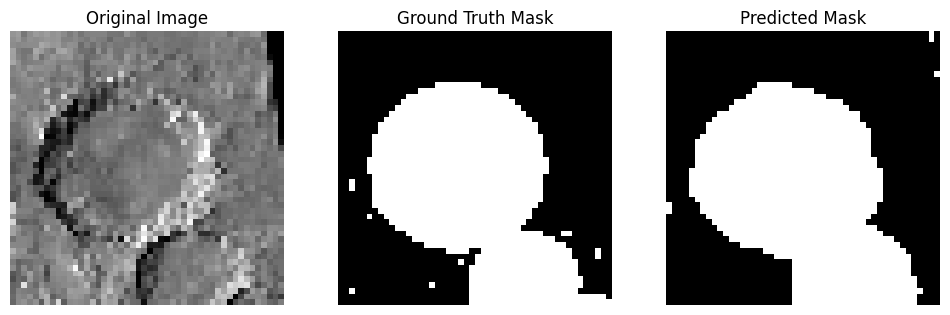

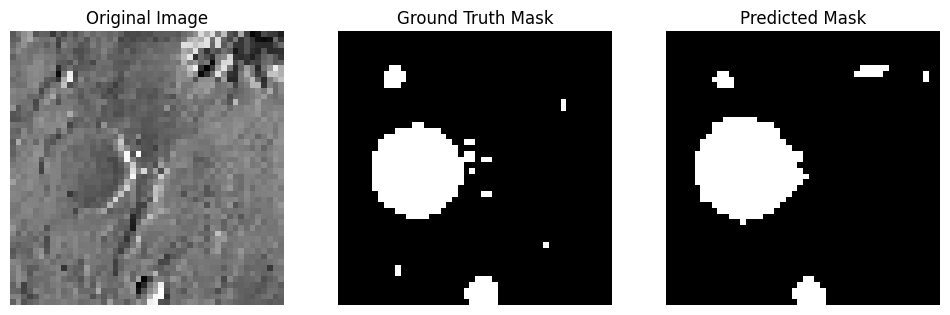

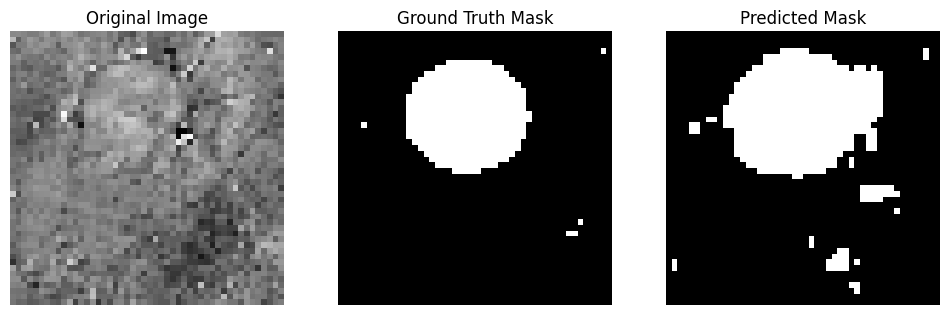

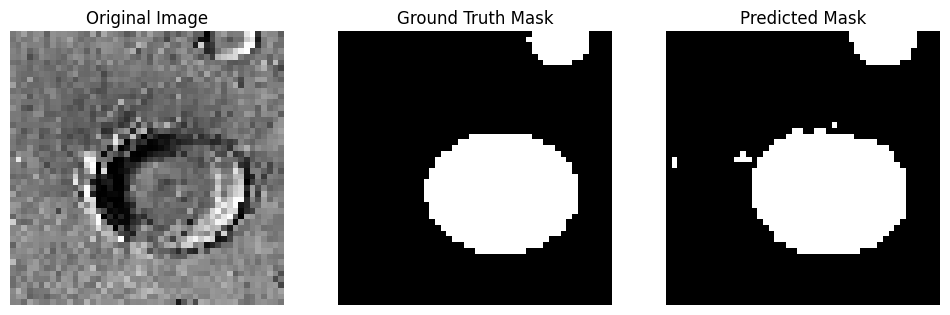

In [107]:
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score
# Example of making predictions
y_pred = model.predict(x_val.reshape(x_val.shape[0], 48, 48, 1))

# Binarize predictions to create binary masks
y_pred_binary = (y_pred > 0.5).astype(np.uint8)

# Flatten the ground truth masks and predicted masks across the entire dataset
y_true_flat = y_val.flatten()
y_pred_flat = y_pred_binary.flatten()

# Calculate balanced accuracy for the entire dataset
balanced_acc = balanced_accuracy_score(y_true_flat, y_pred_flat)

# Output the balanced accuracy
print(f'Balanced Accuracy for the entire model: {balanced_acc:.4f}')

for x in range(0, 10):
    # Reshape the images back to 48x48 for visualization
    original_image = x_val[x].reshape(48, 48)
    ground_truth = y_val[x].reshape(48, 48)
    predicted_mask = y_pred_binary[x].reshape(48, 48)

    # Create a new figure
    plt.figure(figsize=(12, 4))  # Adjust the size to make it wider

    # Show the original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')  # Hide axis

    # Show the ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    # Show the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    # Display the images
    plt.show()



**Cross Validation**

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score
import numpy as np

# Define parameters
num_folds = 5
epochs = 20
batch_size = 16

# Initialize KFold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Placeholder for storing balanced accuracies for each fold
all_fold_balanced_accuracies = []

# Reshape x_train and y_train for the U-Net model
x_train_reshaped = np.reshape(x_combined, (x_combined.shape[0], 48, 48, 1))
y_train_reshaped = np.reshape(y_combined, (y_combined.shape[0], 48, 48, 1))

# Cross-validation loop
fold_no = 1
for train_index, val_index in kf.split(x_train_reshaped):
    print(f'Training on fold {fold_no}...')

    # Split data
    x_train_fold, x_val_fold = x_train_reshaped[train_index], x_train_reshaped[val_index]
    y_train_fold, y_val_fold = y_train_reshaped[train_index], y_train_reshaped[val_index]

    # Sample weights for each fold
    sample_weights = np.zeros_like(y_train_fold, dtype=np.float32)
    sample_weights[y_train_fold == 0] = class_weights[0]
    sample_weights[y_train_fold == 1] = class_weights[1]

    # Initialize model for each fold
    model_1 = unet_model()
    model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model on the current fold
    model_1.fit(x_train_fold, y_train_fold,
              batch_size=batch_size, epochs=epochs,
              sample_weight=sample_weights,
              validation_data=(x_val_fold, y_val_fold))

    # Predict on the validation fold
    y_val_pred = model_1.predict(x_val_fold)
    y_val_pred_binary = (y_val_pred > 0.6).astype(np.int32)  # Convert predictions to binary 0/1 format

    # Flatten y_val and y_val_pred for balanced accuracy calculation
    y_val_flat = y_val_fold.flatten()
    y_val_flat = (y_val_flat > 0.5).astype(np.int32)
    y_val_pred_flat = y_val_pred_binary.flatten()

    # Calculate balanced accuracy for the current fold
    balanced_acc = balanced_accuracy_score(y_val_flat, y_val_pred_flat)
    all_fold_balanced_accuracies.append(balanced_acc)

    print(f'Balanced accuracy for fold {fold_no}: {balanced_acc}')
    fold_no += 1

# Calculate and print average balanced accuracy across all folds
average_balanced_accuracy = np.mean(all_fold_balanced_accuracies)
print(f'Average balanced accuracy across {num_folds} folds: {average_balanced_accuracy}')


Training on fold 1...
Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.4936 - loss: 1.0145 - val_accuracy: 0.3647 - val_loss: 0.6158
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.4972 - loss: 0.6743 - val_accuracy: 0.5139 - val_loss: 0.7357
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5522 - loss: 0.6514 - val_accuracy: 0.6583 - val_loss: 0.8205
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6153 - loss: 0.6371 - val_accuracy: 0.6297 - val_loss: 0.6562
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6369 - loss: 0.6041 - val_accuracy: 0.6083 - val_loss: 0.4702
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6420 - loss: 0.5969 - val_accuracy: 0.6562 - val_loss: 0.6816
Epoch 7/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6568 - loss: 0.5788 - val_accuracy: 0.6975 - val_loss: 0.8012
Epoch 8/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6586 -

**Final**

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(196, 2304)
(196, 2304)


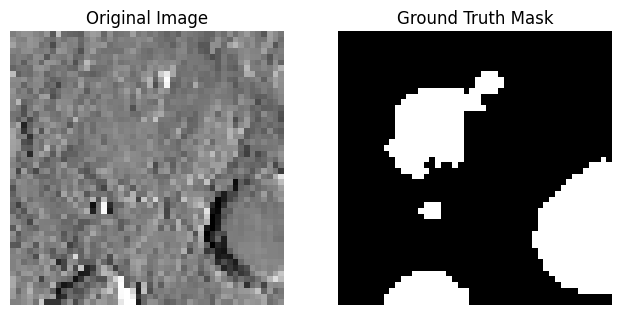

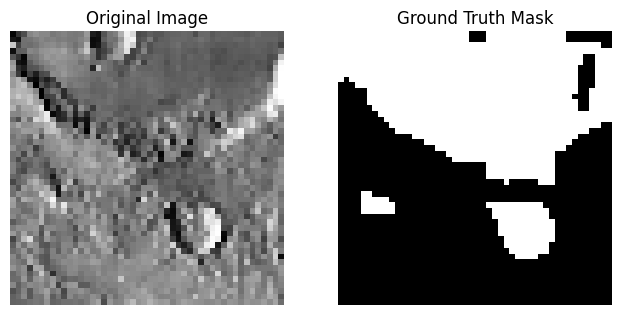

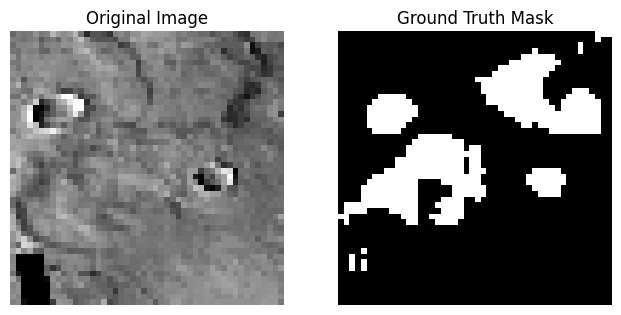

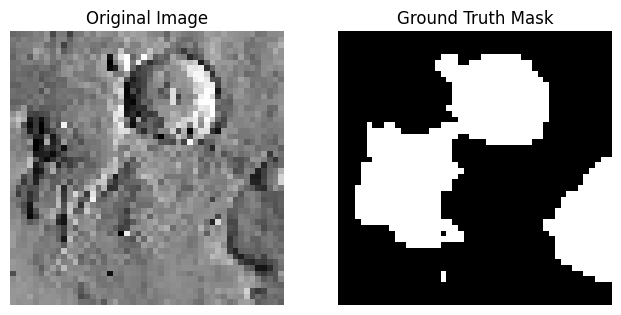

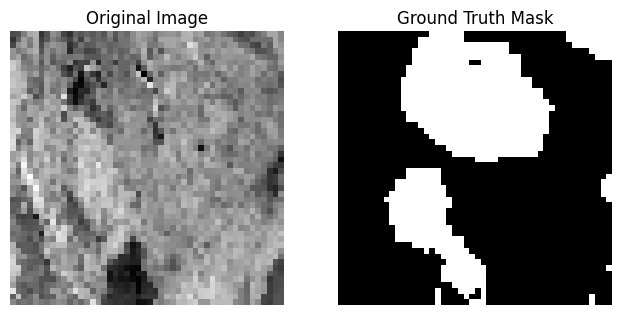

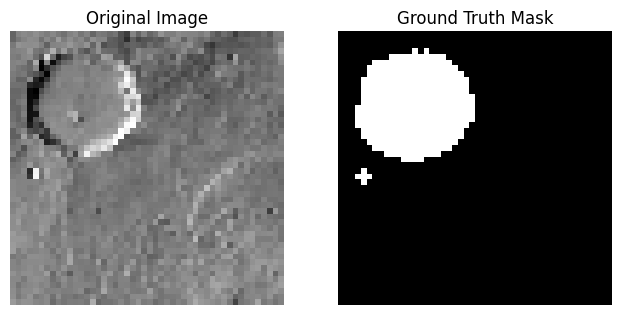

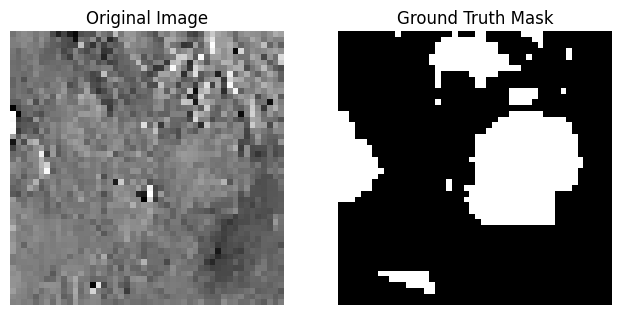

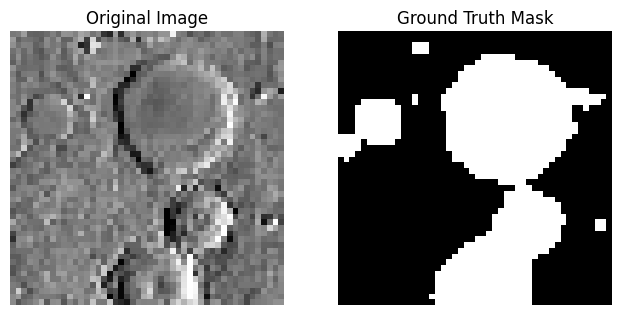

In [110]:
X_test_b_r = np.reshape(X_test_b, (X_test_b.shape[0], 48, 48, 1))

y_pred = model.predict(X_test_b_r)

# Binarize predictions to create binary masks
y_pred_binary = (y_pred > 0.60).astype(np.uint8)
y_pred_binary = y_pred_binary.reshape(196, 48 * 48)
np.save('y_predicted.npy', y_pred_binary) #Guardar vetor a entregar

print(X_test_b.shape)
print(y_pred_binary.shape)
for x in range(0, 10):
    # Reshape the images back to 48x48 for visualization
    original_image = X_test_b[x].reshape(48, 48)
    ground_truth = y_pred_binary[x].reshape(48, 48)

    # Create a new figure
    plt.figure(figsize=(12, 4))  # Adjust the size to make it wider

    # Show the original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')  # Hide axis

    # Show the ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')


    # Display the images
    plt.show()
